In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime

import sys
# Put here the directory containing the folder where the definitions are saved
sys.path.insert(0, r'C:\Users\demdr\UTS\Important files for PhD thesis\Definitions')

from definitions_for_hr_data_processing import add_smoother_HR,create_firstgradediff_forHR,find_HR_mean_and_std_thirtyseconds,detect_faulty_hr_secondstep,calculate_intensity_of_HR
from definitions_for_HR_peak_detection import HR_peak_detection
from definitions_for_reading_density_and_node_maps import import_pois, import_nodes_and_links, construct_KDTree, find_traffic_for_nodes_based_on_links, find_closest_node

In [2]:
# For visualisation

import matplotlib.pyplot as plt
import seaborn as sns
import folium
from IPython.display import IFrame
from IPython.display import display
import branca.colormap

In [3]:
participant_ID = 'A'

#### Import + combine the physiological and movement data for this participant

In [4]:
dfs_to_concat = []


# PATH FOR UPLOADING ANALYSED GPS DATA
# Put here the path of the file that contains speed and altitude data
# (the csv created from the file 'Step 2 - Collect and process data from strava--HR, speed, altitude data' in component 1)
path_for_importing_speed_df = r'C:\Users\demdr\Desktop\Testing the thesis functions\Project data\Analysed data\Participants\A\Speed data\Session 1.csv'




# PUT FOR UPLOADING ANALYSED EDA + ACTIVITY (FROM ACCELEROMETER) DATA:
#Put here the path of the file that contains the processed EDA and activity data after analysis of 
# the Empatica E4 files (containing the raw accelerometer and EDA data)
# (the csv created from the file 'Step 1 - Process accelerometer data.ipynb' in component 1)
path_for_importing_eda_df = r'C:\Users\demdr\Desktop\Testing the thesis functions\Project data\Analysed data\Participants\A\E4 data\Session 1.csv'


#Import speed df
speed_df = pd.read_csv(path_for_importing_speed_df)
speed_df = speed_df.copy().set_index(pd.to_datetime(speed_df['Datetime']))
df = speed_df

#Import EDA df
eda_df = pd.read_csv(path_for_importing_eda_df)
eda_df = eda_df.copy().set_index(pd.to_datetime(eda_df['Datetime']))


# CONVERT TO UTC in case there is a change in timezones during the experiment 
eda_df.index = pd.to_datetime(eda_df.index, utc=True).tz_convert('UTC')

slice_df = df[eda_df.index[0]:eda_df.index[-1]]
slice_df.index = pd.to_datetime(slice_df.index, utc=True).tz_convert('UTC')
#Make a copy of the df containing the EDA data 
eda_df_copy = eda_df.copy().reindex(slice_df.index, method='ffill').fillna(method='bfill').fillna(method='ffill')

slice_df['Heart rate'] = eda_df_copy['HR_from e4'].copy()

eda_df_copy.index = pd.to_datetime(eda_df_copy.index, utc=True)
slice_df.index = pd.to_datetime(slice_df.index, utc=True)

# Analyse HR data and create a df to store it temporarily
hr_df = pd.DataFrame()
for ses in slice_df['Session'].unique():
    print(ses)
    session_df = slice_df[slice_df['Session']==ses].copy()

    #Mark data points with faulty HR data if present
    session_df = detect_faulty_hr_secondstep(session_df, 'Heart rate','faulty_HR')
    #Compute features for HR data analysis
    session_df = create_firstgradediff_forHR(session_df)
    session_df['HR_dif'] = round(session_df['HR_dif'], 2)
    session_df = find_HR_mean_and_std_thirtyseconds(session_df)
    #Calculate intensity of activity based on age (this is optional, we do not use it anywhere else 
    # but it is useful information). Replace 30 with the age of the participant
    participant_age = 30
    session_df = calculate_intensity_of_HR(session_df,participant_age)
    #Ad HR peak detection:
    if session_df['faulty_HR'].mean()!=1:
        session_df = HR_peak_detection(session_df.copy(),5, 'Heart rate')
    hr_df = hr_df.append(session_df)

# Combine the df containing the HR data and the processed EDA data
fusion_df = pd.concat([hr_df, eda_df_copy], axis=1)

if 'EDA artifact.1' in fusion_df.columns:
    if fusion_df['EDA artifact'].all()==fusion_df['EDA artifact.1'].all():
        fusion_df = fusion_df.drop(['EDA artifact.1'],axis=1)
if 'EDR_duration.1' in fusion_df.columns:
    if fusion_df['EDR_duration'].all()==fusion_df['EDR_duration.1'].all():
        fusion_df = fusion_dff.drop(['EDR_duration.1'],axis=1)

# Remove duplicates
fusion_df = fusion_df.loc[:, ~fusion_df.columns.duplicated()].fillna(0)
# Here replace with the appropriate time zone if needed
fusion_df.index = fusion_df.index.tz_convert('Australia/Sydney')
fusion_df


#dfs_to_concat.append(together_df)

c:\users\demdr\python37\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


A_16-07-2019 13:09


,Datetime,Latitude,Longitude,Altitude,Heart rate,Session,UserID,Distance,Time_Passed,Speed,...,EDR_amplitude,EDA_duration,EDA_duration.1,percentage_of_EDA_artifacts,activity,activity_2s,Change of activity state,Steady state,Change of movement intensity,Spontaneous movement
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-07-16 13:09:58+10:00,2019-07-16 13:09:58+10:00,-33.882959,151.202252,26.9,55.00000,A_16-07-2019 13:09,A,3.94,4.0,2.7,...,0.000000,0.00,0.00,0.002201,2,3,0,0,0,0
2019-07-16 13:10:03+10:00,2019-07-16 13:10:03+10:00,-33.882988,151.202222,26.9,55.00000,A_16-07-2019 13:09,A,4.25,5.0,2.9,...,0.000000,0.00,0.00,0.002201,2,2,0,0,0,0
2019-07-16 13:10:08+10:00,2019-07-16 13:10:08+10:00,-33.883018,151.202196,26.9,56.90625,A_16-07-2019 13:09,A,4.11,5.0,2.8,...,0.058571,4.00,4.00,0.002201,2,3,0,0,0,0
2019-07-16 13:10:13+10:00,2019-07-16 13:10:13+10:00,-33.883034,151.202183,26.9,64.71750,A_16-07-2019 13:09,A,2.14,5.0,2.6,...,0.000000,0.00,0.00,0.002201,2,2,0,0,1,0
2019-07-16 13:10:14+10:00,2019-07-16 13:10:14+10:00,-33.883037,151.202181,26.9,65.54750,A_16-07-2019 13:09,A,0.38,1.0,2.1,...,0.000000,0.00,0.00,0.002201,2,2,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-16 13:51:07+10:00,2019-07-16 13:51:07+10:00,-33.883000,151.202275,27.0,81.21750,A_16-07-2019 13:09,A,0.00,5.0,-0.2,...,0.184516,2.50,2.50,0.002201,1,3,0,0,1,0
2019-07-16 13:51:12+10:00,2019-07-16 13:51:12+10:00,-33.883000,151.202275,27.0,80.03375,A_16-07-2019 13:09,A,0.00,5.0,-0.2,...,0.249329,3.50,3.50,0.002201,1,2,0,0,1,0
2019-07-16 13:51:17+10:00,2019-07-16 13:51:17+10:00,-33.883000,151.202275,27.0,79.28375,A_16-07-2019 13:09,A,0.00,5.0,-0.1,...,0.000000,0.00,0.00,0.002201,1,2,0,0,1,0


# FUSION WITH SPATIAL DATA

#### Import POI database

In [5]:

#Import node csv from the directory where the data for the Spatial database is saved
nodes_dir = r'C:\Users\demdr\Desktop\Testing the thesis functions\Project data\Spatial database\Urban network analysis_'
import_nodes = import_nodes_and_links(nodes_dir)
#get dataframe with street network nodes
node_csv = import_nodes[0]
#and the dataframe with street network links 
link_csv = import_nodes[1]
node_csv

#Construct KD-Trees (spatial proximity info)
node_tree = construct_KDTree(node_csv, 'y','x')
#Add traffic column in the node csv if it is not there
if 'traffic' not in node_csv.columns:
    node_csv = find_traffic_for_nodes_based_on_links(node_csv,link_csv)

node_csv

,y,x,osmid,ref,highway,geometry,Closest Poi Density,Closest Poi Distance,Closest Poi Index,Closest Poi Density_with distance decay,traffic
Unnamed: 0.1,,,,,,,,,,,
4032839686,-33.884170,151.206674,4032839686,NaN,NaN,POINT (151.2066739 -33.8841699),23.0,51.395745,1008.0,23.0,0.0
5603655691,-33.889497,151.208640,5603655691,NaN,NaN,POINT (151.2086402 -33.8894974),19.0,55.902375,1060.0,16.0,0.0
5603655694,-33.889278,151.208666,5603655694,NaN,NaN,POINT (151.2086659 -33.8892777),3.0,49.442273,1143.0,1.0,0.0
5603655695,-33.889505,151.208731,5603655695,NaN,NaN,POINT (151.2087313 -33.8895051),16.0,60.820926,1039.0,16.0,0.0
5603655696,-33.889432,151.208740,5603655696,NaN,NaN,POINT (151.2087396 -33.8894318),3.0,60.132376,1143.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1846288364,-33.889820,151.199394,1846288364,NaN,NaN,POINT (151.1993935 -33.8898197),11.0,104.125530,146.0,9.0,0.0
5243953133,-33.885422,151.206902,5243953133,NaN,NaN,POINT (151.2069021 -33.8854224),26.0,13.717985,276.0,26.0,0.0
1846288366,-33.890985,151.198651,1846288366,NaN,NaN,POINT (151.1986507 -33.8909847),14.0,33.273068,1233.0,14.0,0.0


In [30]:
# Put the userID if it is not already in the columns
if 'UserID' not in fusion_df.columns:
    fusion_df['UserID']=str(participant_ID)

#### Visualise some of the extracted EDA features

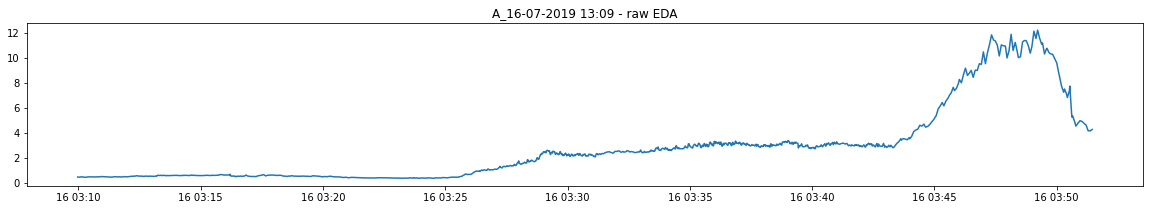

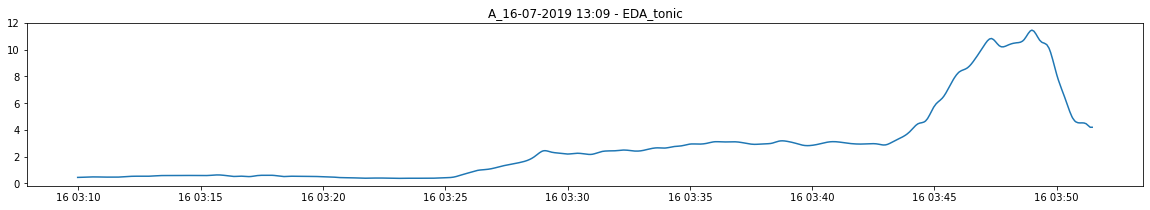

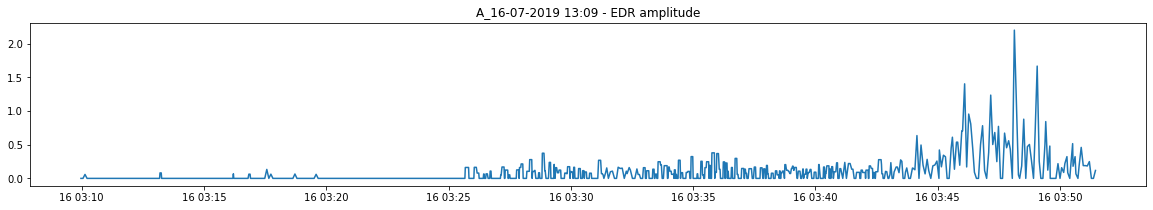

In [7]:
fusion_df = fusion_df.fillna(0)
for ses in fusion_df['Session'].unique():
    this_session = fusion_df[fusion_df['Session']==ses]
    plt.figure(figsize=(20,3))
    plt.plot(this_session['EDA'])
    plt.title(ses + ' - raw EDA')
    plt.figure(figsize=(20,3))
    plt.plot(this_session['EDA_tonic'])
    plt.title(ses + ' - EDA_tonic')
    plt.figure(figsize=(20,3))
    plt.plot(this_session['EDR_amplitude'])
    plt.title(ses + ' - EDR amplitude')

#### add the following contextual features: 
density, traffic, traffic signal time passed since beginning of activity

In [8]:
fusion_df['Density']=0
fusion_df['Traffic']=0
fusion_df['Density_diff']=0
fusion_df['Total seconds passed']=0
fusion_df['Traffic signal']=0


for ses in fusion_df['Session'].unique():
    this_session = fusion_df[fusion_df['Session']==ses].copy()


    density_data = []
    traffic_data = []

    for i in range(0, len(this_session.index)):

        this_pt = [this_session.loc[this_session.index[i], 'Latitude'],this_session.loc[this_session.index[i], 'Longitude']]
        closest_node = find_closest_node(node_tree, this_pt[0],this_pt[1])
        this_density=node_csv.loc[node_csv.index[closest_node[1][0]], 'Closest Poi Density_with distance decay']
        this_traffic=node_csv.loc[node_csv.index[closest_node[1][0]], 'traffic']
        density_data.append(this_density)
        traffic_data.append(this_traffic)

        #add time passed since the beginning of the activity
        previous_points = this_session[this_session.index[0]:this_session.index[i]]['Time_Passed']
        fusion_df.loc[this_session.index[i], 'Total seconds passed']=np.sum(np.array(previous_points))

        #Identify if there is a traffic signal close to each GPS point
        if node_csv.loc[node_csv.index[closest_node[1][0]], 'highway']=='traffic_signals':
            fusion_df.loc[this_session.index[i], 'Traffic signal']=1



    fusion_df.loc[this_session.index, 'Density']=pd.Series(density_data).values
    fusion_df.loc[this_session.index,'Traffic']=pd.Series(traffic_data).values
    fusion_df.loc[this_session.index,'Density_diff']=fusion_df['Density'].diff().fillna(0)

   

#### # Normalise the EDA tonic and EDA amplitude after finding the max values and scaling the 2 signals based on the max values 


In [9]:
def perform_minmax(df, col, this_max):
    to_be_minmaxed = np.array(df[col])
    minmaxed = (to_be_minmaxed - to_be_minmaxed.min())/(this_max-to_be_minmaxed.min())
    return(minmaxed)

# Store the raw EDA tonic and EDA amplitude values for future reference
fusion_df['EDA_tonic before minmax']=fusion_df['EDA_tonic'].copy()
fusion_df['EDR_amplitude before minmax']=fusion_df['EDR_amplitude'].copy()

    

#IMPORTANT NOTE: if we have other data available for this participant, then we need to import here all their 
# available data and get the maximum EDA and EDA amplitude from all their available data, not just this file
# This is not included here, extra code can be added if needed 
EDA_tonic_max = fusion_df['EDA_tonic'].max()
EDR_amplitude_max = fusion_df['EDR_amplitude'].max()
print('max EDA:', EDA_tonic_max)
print('max EDR amplitude:', EDR_amplitude_max)

for ses in fusion_df['Session'].unique():
    this_session = fusion_df[fusion_df['Session']==ses].copy()
    tonic_normalized = perform_minmax(this_session, 'EDA_tonic', EDA_tonic_max)
    amplitude_normalized = perform_minmax(this_session, 'EDR_amplitude', EDR_amplitude_max)
    fusion_df.loc[this_session.index, 'EDA_tonic'] = tonic_normalized
    fusion_df.loc[this_session.index, 'EDR_amplitude'] = amplitude_normalized
fusion_df = fusion_df.fillna(method='bfill').fillna(0)

max EDA: 11.450511668050234
max EDR amplitude: 2.2005743750000004


## Create columns for: 
- number of EDRs (EDR frequency)
- sum of responses (sum of EDR amplitudes)
- min,max,mean, std POI Density
- EDA tonic change

In [11]:
fusion_df['number of EDR responses']=0
fusion_df['Sum of EDR amplitudes']=0
fusion_df['min_Density']=0
fusion_df['std_Density']=0
fusion_df['max_Density']=0
fusion_df['mean_Density']=0
fusion_df['EDA_tonic_change']=0



for ses in fusion_df['Session'].unique():
    this_session = fusion_df[fusion_df['Session']==ses].copy()

    # Create a helper df which is resampled in 1-minute frequency 
    # Compute the following features for each 1-min time window:
    #'number of EDR responses' : corresponds to EDR frequency
    #Sum of EDR amplitudes 
    #'EDA_tonic_change' : Change in tonic EDA for each minute
    # Minimum, std, mean and max POI density
    one_min_df = this_session.resample('60s').mean().copy()
    one_min_int = np.arange(len(one_min_df))
    one_min_df['one_min sessions']=one_min_int
    helper = this_session.copy()
    helper['one_min sessions'] = one_min_df['one_min sessions'].copy().reindex(helper.index, method='ffill')

    for item in helper['one_min sessions'].unique():
        subdf = helper[helper['one_min sessions']==item].copy()
        # Calculate EDR frequency (number of EDR responses) for this 1-min time window
        helper.loc[subdf.index, 'number of EDR responses']=len(subdf['EDR_amplitude'].unique())
        # Calculate POI density features for 1-min time window
        helper.loc[subdf.index, 'min_Density']=subdf['Density'].min()
        helper.loc[subdf.index, 'max_Density']=subdf['Density'].max()
        helper.loc[subdf.index, 'std_Density']=subdf['Density'].std()
        helper.loc[subdf.index, 'mean_Density']=subdf['Density'].mean()
        # Calculate change in tonic EDA for 1-min time window
        if item>1:
            EDA_tonic_change = subdf['EDA_tonic'].mean()-helper[helper['one_min sessions']==item-1]['EDA_tonic'].mean()
            helper.loc[subdf.index, 'EDA_tonic_change']=EDA_tonic_change
        else:
            helper.loc[subdf.index, 'EDA_tonic_change']=0


        #calculate sum of EDR amplitudes:
        amplitude_array = np.zeros(len(subdf[subdf['EDA_session']>0]['EDA_session'].unique()))
        cnt=0
        for EDA_ses in subdf[subdf['EDA_session']>0]['EDA_session'].unique():
            this_ses = subdf[subdf['EDA_session']==EDA_ses]
            amplitude_array[cnt]=this_ses.loc[this_ses.index[0],'EDR_amplitude']
            cnt+=1

        helper.loc[subdf.index, 'Sum of EDR amplitudes']=np.sum(amplitude_array)

    # Copy the features to the original df
    fusion_df.loc[this_session.index, 'number of EDR responses']=helper['number of EDR responses']
    fusion_df.loc[this_session.index,'Sum of EDR amplitudes']=helper['Sum of EDR amplitudes']

    fusion_df.loc[this_session.index,'min_Density']=helper['min_Density']
    fusion_df.loc[this_session.index,'std_Density']=helper['std_Density']
    fusion_df.loc[this_session.index,'max_Density']=helper['max_Density']
    fusion_df.loc[this_session.index,'mean_Density']=helper['mean_Density']
    fusion_df.loc[this_session.index,'EDA_tonic_change']=helper['EDA_tonic_change']

#### Also create a column storing the presence of any change in activity 
including spontaneous changes, changes in activity state, generally any detected change in movement

In [12]:
fusion_df['Change of activity']=0
fusion_df.loc[fusion_df[(fusion_df['Change of activity state']==1)|(fusion_df['Change of movement intensity']==1)|(fusion_df['Spontaneous movement']==1)].index, 'Change of activity']=1


### Create a df which is resampled at 60s and use it to identify changes in EDA measures, activity and spatial parameters


In [13]:
fusion_df['Significant Changes:EDA']=0
fusion_df['Significant Changes:Sum of EDR amplitudes']=0
fusion_df['Significant Changes:Steady state walking']=0
fusion_df['Significant Changes:Heart rate']=0
                
fusion_df['Significant Changes:Activity'] = 0
fusion_df['Significant Changes:Traffic'] = 0
fusion_df['Significant Changes:Density'] = 0



for ses in fusion_df['Session'].unique():
    this_session = fusion_df[fusion_df['Session']==ses].copy()
    print(this_session.index[0])

    index_resampled = this_session.resample('60s').mean()


    for i in range(0, len(index_resampled.index[1:-2])):
        # Index of this second
        this_index = index_resampled.index[1:][i]
        # Previous index: 1 minute before this second
        prev_index = index_resampled.index[1:][i-1]
        # Next index: 1 minute after this second
        next_index = index_resampled.index[1:][i+1]
        final_index = index_resampled.index[1:][i+2]

        # Find the mean values of different contextual and movement data (POI density, traffic, activity)
        # for different time points: this minute, 1 minute before and 1 minute after 
        # We compute the density and traffic also for 1 minute after this second, because 
        # the spatial data signifying intenst POI density and traffic may have small inaccuracies 
        prev_density = this_session.loc[prev_index:this_index,'Density'].mean()
        this_density = this_session.loc[this_index:next_index,'Density'].mean()
        next_density = this_session.loc[next_index:final_index,'Density'].mean()
        prev_traffic = this_session.loc[prev_index:this_index,'Traffic'].mean()
        this_traffic = this_session.loc[this_index:next_index,'Traffic'].mean()
        next_traffic = this_session.loc[next_index:final_index,'Traffic'].mean()
        prev_activity = this_session.loc[prev_index:this_index,'activity'].mean()
        this_activity = this_session.loc[this_index:next_index,'activity'].mean()
        # Find the mean values of physiological data (Tonic EDA, sum of EDR amplitudes, HR)
        # for different time points: this minute, and 1 minute before 
        prev_EDA = this_session.loc[prev_index:this_index,'EDA_tonic'].mean()
        this_EDA = this_session.loc[this_index:next_index,'EDA_tonic'].mean()
        prev_amplitude = this_session.loc[prev_index:this_index,'Sum of EDR amplitudes'].mean()
        this_amplitude = this_session.loc[this_index:next_index,'Sum of EDR amplitudes'].mean()
        prev_HR = this_session.loc[prev_index:this_index,'Heart rate'].mean()
        this_HR = this_session.loc[this_index:next_index,'Heart rate'].mean()



        # Change in steady state walking
        steady_state_df = this_session[(this_session['activity']==2)&(this_session['Steady state']==1)]
        this_session['Steady state walking']=0
        this_session.loc[steady_state_df.index, 'Steady state walking']=1
        this_steady_state_walking = this_session.loc[this_index:next_index,'Steady state walking'].mean()
        prev_steady_state_walking = this_session.loc[prev_index:this_index,'Steady state walking'].mean()


        density_change = 0
        traffic_change = 0
        activity_change = 0
        steady_state_change = 0

        # Thresholds for detection of significant changes in POI density, traffic and activity:      
        # POI Density threshold: 0.5*STD of POI density data
        d_l = 5
        # Traffic threshold: Approximately 1 STD of traffic data
        t_l = 1
        # Activity threshold : 1 STD of activity intensity data
        act_l = 0.5
        # Steady state walking threshold: 1 STD of steady state data
        st_l = 0.4


        #Detect significant changes in POI density, traffic and activity based on the thresholds
        #1,2,3 correspond to low, medium and intense changes respectively
        if (abs(this_density-prev_density)>=d_l) | (abs(this_density-next_density)>=d_l):
            density_change = 1
        if (abs(this_traffic-prev_traffic)>=t_l) | (abs(this_traffic-next_traffic)>=t_l):
            traffic_change = 1
        if abs(this_activity-prev_activity)>=act_l:
            activity_change = 1
        if abs(this_steady_state_walking-prev_steady_state_walking)>=st_l:
            steady_state_change=1


        # Put the info in the initial, non-resampled df
        fusion_df.loc[this_index:next_index, 'Significant Changes:EDA']=abs(this_EDA-prev_EDA)
        fusion_df.loc[this_index:next_index, 'Significant Changes:Sum of EDR amplitudes']=prev_amplitude-this_amplitude
        fusion_df.loc[this_index:next_index, 'Significant Changes:Steady state walking']=steady_state_change
        fusion_df.loc[this_index:next_index, 'Significant Changes:Heart rate']=this_HR-prev_HR


        fusion_df.loc[this_index:next_index, 'Significant Changes:Activity'] = activity_change
        fusion_df.loc[this_index:next_index, 'Significant Changes:Traffic'] = traffic_change
        fusion_df.loc[this_index:next_index, 'Significant Changes:Density'] = density_change

fusion_df = fusion_df.fillna(0)

2019-07-16 13:09:58+10:00


#### Visualise some of the resulting EDA features


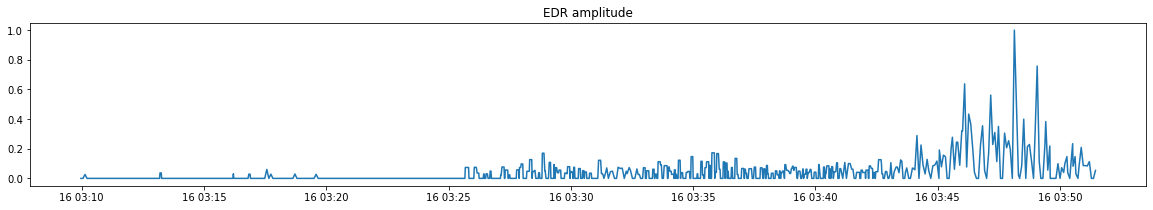

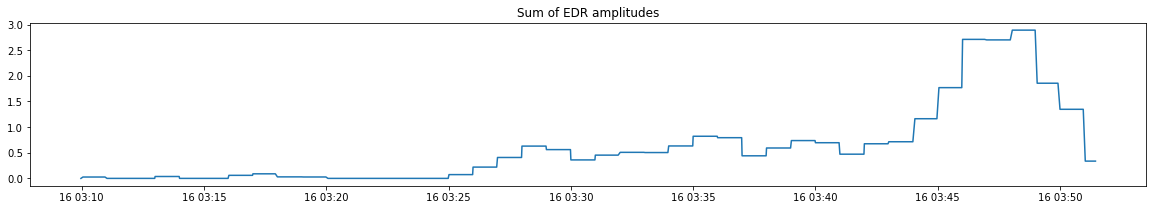

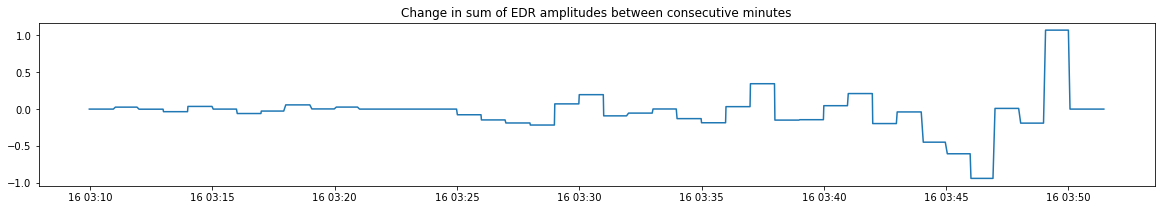

In [14]:
for ses in fusion_df['Session'].unique():
    this_session = fusion_df[fusion_df['Session']==ses]
    plt.figure(figsize=(20,3))
    plt.plot(this_session['EDR_amplitude'])
    plt.title('EDR amplitude')
    plt.figure(figsize=(20,3))
    plt.plot(this_session['Sum of EDR amplitudes'])
    plt.title('Sum of EDR amplitudes')
    plt.figure(figsize=(20,3))
    plt.plot(this_session['Significant Changes:Sum of EDR amplitudes'])
    plt.title('Change in sum of EDR amplitudes between consecutive minutes')


#### Include temperature data

In [15]:
# Way 1: Check existing historical data from online sources etc. and put it manually in the csv
# First create a new column to store temperature data if it does not exist already
if 'Temperature' not in fusion_df.columns:
    fusion_df['Temperature']=0
# Put the temperature data for each session
for user in fusion_df['UserID'].unique():
    this_df = fusion_df[fusion_df['UserID']==user]
    for ses in this_df['Session'].unique():
        print(ses)
        this_ses = this_df[this_df['Session']==ses]
        temp = input('Enter temperature (in Celsius)')
        fusion_df.loc[this_ses.index, 'Temperature']=temp
        
fusion_df['Temperature']=fusion_df['Temperature'].astype(int)
#Alternatively, we can  import historical temperature data from another csv or any other source, 
#if they are not already included in the data collected with the sensors.

#This should include the following steps:
#- Import a csv with the temperature data
#- Resample this csv so that it matches the 'fusion_df' csv that we have with the GPS, physiological, contextual data etc.
#- Transfer the data from there to the csv called 'fusion_df'
#- Create a new column called fusion_df['Temperature'] to store the temperature data in celsius

A_16-07-2019 13:09
Enter temperature (in Celsius)21


#### Assign physical + psychological stressors for classification of physiological responses

In [16]:
# Note: We put traffic signals as both physical and psychological stressors, as they may influence activity 
# but they may also be associated with higher frustration or stress from noise, honks etc. 

# First assign physical stressors
fusion_df['Physical stressors']=0
fusion_df['Physical stressor type']=''
fusion_df.loc[fusion_df[fusion_df['Change of activity']==1].index, 'Physical stressors']=fusion_df.loc[fusion_df[fusion_df['Change of activity']==1].index, 'Physical stressors']+1
fusion_df.loc[fusion_df[fusion_df['Change of activity']==1].index, 'Physical stressor type']=fusion_df.loc[fusion_df[fusion_df['Change of activity']==1].index, 'Physical stressor type']+ '- Change of activity '
# Add the duration of activity as a physical stressor, when the time since beginning of activity is >15 minutes
fusion_df.loc[fusion_df[fusion_df['Total seconds passed']>=900].index, 'Physical stressors']=fusion_df.loc[fusion_df[fusion_df['Total seconds passed']>=900].index, 'Physical stressors']+ 1
fusion_df.loc[fusion_df[fusion_df['Total seconds passed']>=900].index, 'Physical stressor type']=fusion_df.loc[fusion_df[fusion_df['Total seconds passed']>=900].index, 'Physical stressor type']+ ' - Duration of activity'
# At the moment we also add Traffic signal in this category 
fusion_df.loc[fusion_df[fusion_df['Traffic signal']==1].index, 'Physical stressors']=fusion_df['Physical stressors']+1
fusion_df.loc[fusion_df[fusion_df['Traffic signal']==1].index, 'Physical stressor type']=fusion_df['Physical stressor type']+ ' - Traffic signal'
# Finally, add slope
if 'Altitude change_slope' in fusion_df.columns:
    fusion_df.loc[fusion_df[fusion_df['Altitude change_slope']>0].index, 'Physical stressors']=fusion_df.loc[fusion_df[fusion_df['Altitude change_slope']>0].index, 'Physical stressors']+1
    fusion_df.loc[fusion_df[fusion_df['Altitude change_slope']>0].index, 'Physical stressor type']=fusion_df.loc[fusion_df[fusion_df['Altitude change_slope']>0].index, 'Physical stressor type']+ ' - Slope'

fusion_df.loc[fusion_df[fusion_df['Physical stressor type']==''].index, 'Physical stressor type']='None'

# Now assign psychological stressors
fusion_df['Psychological stressors']=0
fusion_df['Psychological stressor type']=''
#Add changes in density
fusion_df.loc[fusion_df[fusion_df['Significant Changes:Density']==1].index, 'Psychological stressors']=fusion_df['Psychological stressors']+1
fusion_df.loc[fusion_df[fusion_df['Significant Changes:Density']==1].index, 'Psychological stressor type']=fusion_df['Psychological stressor type'] + ' - Density change'
#Changes in traffic
fusion_df.loc[fusion_df[fusion_df['Significant Changes:Traffic']==1].index, 'Psychological stressors']=fusion_df['Psychological stressors']+1
fusion_df.loc[fusion_df[fusion_df['Significant Changes:Traffic']==1].index, 'Psychological stressor type']=fusion_df['Psychological stressor type'] + ' - Traffic change'
#High density
fusion_df.loc[fusion_df[fusion_df['Density']>=15].index, 'Psychological stressors']=fusion_df['Psychological stressors']+1
fusion_df.loc[fusion_df[fusion_df['Density']>=15].index, 'Psychological stressor type']=fusion_df['Psychological stressor type']+ ' - Density'

#High traffic levels
fusion_df.loc[fusion_df[fusion_df['Traffic']>=3].index, 'Psychological stressors']=fusion_df['Psychological stressors']+1
fusion_df.loc[fusion_df[fusion_df['Traffic']>=3].index, 'Psychological stressor type']=fusion_df['Psychological stressor type']+' - Traffic'
#Presence of traffic signal
fusion_df.loc[fusion_df[fusion_df['Traffic signal']==1].index, 'Psychological stressors']=fusion_df['Psychological stressors']+1
fusion_df.loc[fusion_df[fusion_df['Traffic signal']==1].index, 'Psychological stressor type']=fusion_df['Psychological stressor type']+ ' - Traffic signal'

fusion_df.loc[fusion_df[fusion_df['Psychological stressor type']==''].index, 'Psychological stressor type']='None'

fusion_df['Combination of stressor type']=''
fusion_df.loc[fusion_df.index, 'Combination of stressor type'] = fusion_df['Physical stressor type'] + ' - ' + fusion_df['Psychological stressor type']

In [17]:
plt.style.use('seaborn-whitegrid')
User_Letter = participant_ID # this is for constructing the figure titles later

#### Colour scheme for visualisation of the stressors

In [18]:
stressor_color_dict = dict({
        'Only physical stressors-Duration of activity':'peachpuff',
        'Only physical stressors-Change of activity':'gold',
        'Only physical stressors-Slope':'orange',
        'Only physical stressors-Multiple':'red',
        'Only psychological stressors-Traffic':'mediumturquoise',
        'Only psychological stressors-Density':'steelblue',
        #'Only psychological stressors-Traffic signal':''
        'Only psychological stressors-multiple':'darkslategrey',
        'Both physical and psychological stressors':'mediumorchid',
        'No identifiable source':'lightgrey',
        0:'lightgrey',
        '0':'lightgrey',
        'Only physical stressors':'salmon',
        'Only psychological stressors':'lightskyblue'
    })
    
size_dict = dict({
    'Only physical stressors':200,
    'Only psychological stressors':200,
    'Both physical and psychological stressors':400,
    0:1,
    '0':1,
    'No identifiable source':200
    })

physical_stressor_dict = dict({
        'Duration of activity':'peachpuff',
        'Change of activity':'gold',
        'Slope':'orange',
        'Multiple physical stressors':'red',
        'Traffic':'mediumturquoise',
        'Density':'steelblue',
        #'Only psychological stressors-Traffic signal':''
        'Multiple psychological stressors':'darkslategrey',
        'Both physical and psychological stressors':'mediumorchid',
        'No identifiable source':'lightgrey',
        0:'lightgrey',
        'Only physical stressors':'salmon',
        'Only psychological stressors':'lightskyblue'
    })

# Extraction of physiological responses from HR data
- peak detection method 
- AHR method

In [19]:
# Do this in case the GPS data did not come from strava 
# (which could happen if we collect it with a dedicated sensor)
# In this case, there is no altitude data from strava and we just create a column where all altitude + altitude 
# change data is 0
if 'Altitude change_slope' not in fusion_df.columns:
    fusion_df['Altitude change_slope']=0

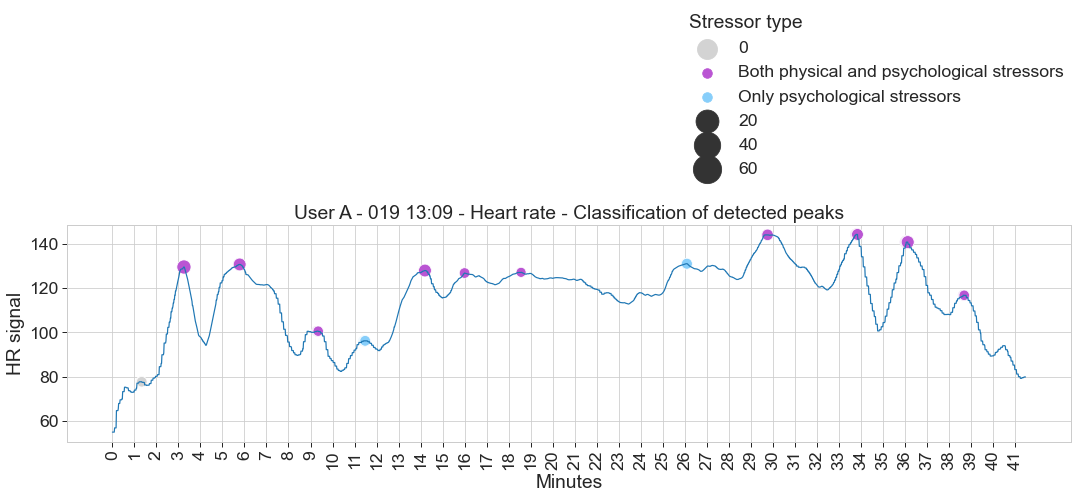

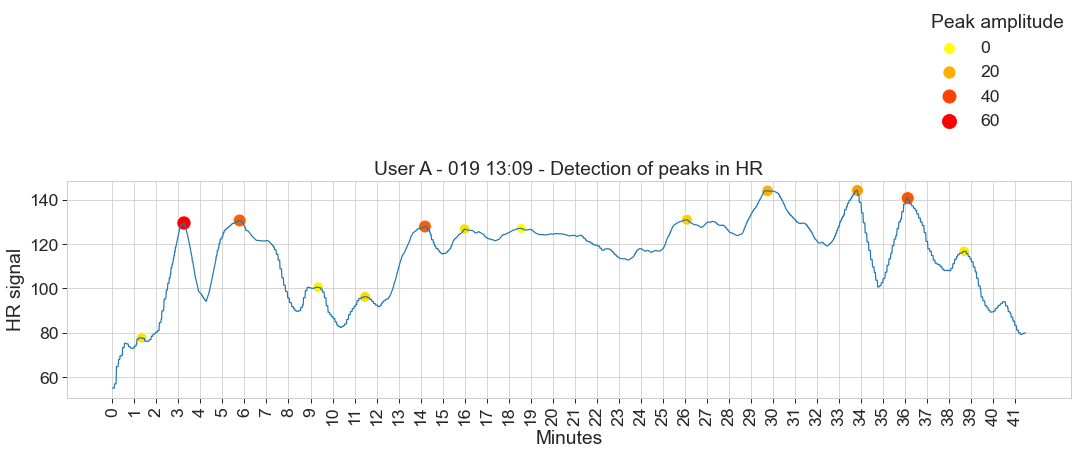

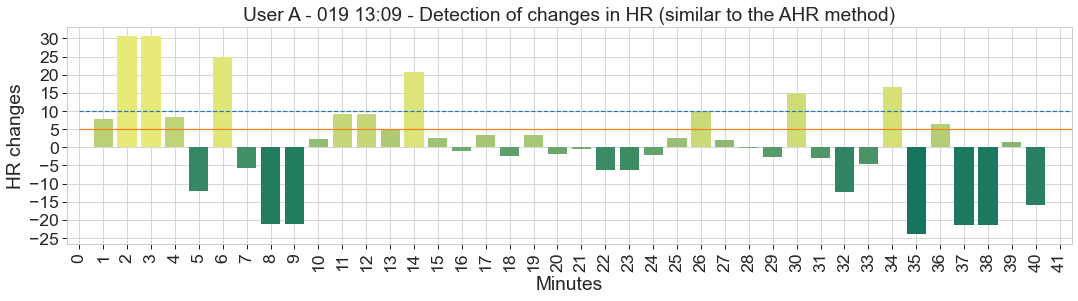

In [26]:
sns.set_context('paper',font_scale=2)

for ses in fusion_df['Session'].unique():
    this_session = fusion_df[fusion_df['Session']==ses].copy()
    # Sometimes some seconds are not included in the index and we have to include them to create even bars
    this_session = this_session.resample('1s').mean().fillna(method='bfill').fillna(method='ffill')
    this_session['Index']=this_session.index
    this_session['Xticks']=np.arange(len(this_session))


    # Make the values integers for the data that we are displaying (because they are displayed as floats in the legend)
    this_session['Total seconds passed'] = this_session['Xticks'].astype('int64')
    this_session['Density'] = this_session['Density'].astype('int64')
    this_session['Traffic'] = this_session['Traffic'].astype('int64')
    this_session['Traffic signal'] = this_session['Traffic signal'].astype('int64')


    # ------Make some new columns for visualisation of physical and psychological stressors
    # Assign distinction between physical and psychological stressors (basic categorization)
    this_session['Stressor type']=0
    this_session.loc[this_session[(this_session['Physical stressors']>0) & (this_session['Psychological stressors']==0)].index,'Stressor type']='Only physical stressors'
    this_session.loc[this_session[(this_session['Physical stressors']==0) & (this_session['Psychological stressors']>0)].index,'Stressor type']='Only psychological stressors'
    this_session.loc[this_session[(this_session['Physical stressors']>0) & (this_session['Psychological stressors']>0)].index,'Stressor type']='Both physical and psychological stressors'
    this_session.loc[this_session[(this_session['Physical stressors']==0) & (this_session['Psychological stressors']==0)].index,'Stressor type']='No identifiable source'

    # Mark significant changes in HR
    this_session['Significant change in HR']=0
    this_session.loc[this_session[this_session['Significant Changes:Heart rate']>10].index, 'Significant change in HR']=1




    # Assign stressors for HR peaks
    this_session['HR peak max']=0
    this_session['Stressor type - HR']=0

    for p in this_session[this_session['HR_peak_session']>0]['HR_peak_session'].unique():
        p_df = this_session[this_session['HR_peak_session']==p]
        if p_df['HR_amplitude'].mean()>5:
            max_pt = p_df[p_df['Heart rate']==p_df['Heart rate'].max()].index
            this_session.loc[max_pt, 'HR peak max']=p_df['HR_amplitude'].mean()

            # For HR, we consider: change in activity, change in psychological stressors
            # but not the duration of activity 
            # To construct a 1-min time window, get the index 1 minute before this moment 
            prev_index = p_df.index[0]-dt.timedelta(minutes=1)
            # Also construct a 1-min time window after this moment for checking psychological stressors 
            # and 10-seconds after this moment for checking physical stressors 
            next_index_phys = p_df.index[0]+dt.timedelta(seconds=10)
            next_index_psych = p_df.index[0]+dt.timedelta(minutes=1)
            if prev_index in this_session.index:
                
                activity_stressors = this_session[prev_index:next_index_phys]
                psychological_stressors = this_session[prev_index:next_index_psych]
                # counter for physical stressors
                physical_cnt = 0
                # counter for psychological stressors
                psychological_cnt = 0
                # check if there is a physical/psychological stressor during this time window 
                # and if there is, increase the value of the counter accordingly
                if 1 in activity_stressors['Change of activity'].unique():
                    physical_cnt+=1
                if (activity_stressors['Altitude change_slope'].max()>0)|(activity_stressors['Altitude change_slope'].min()<0):
                    physical_cnt+=1
                if 1 in psychological_stressors['Traffic signal'].unique():
                    physical_cnt+=1
                    psychological_cnt+=1
                if psychological_stressors['Traffic'].max()>=3:
                    psychological_cnt+=1
                if psychological_stressors['Density'].max()>=15:
                    psychological_cnt+=1
                if 1 in psychological_stressors['Significant Changes:Density'].unique():
                    psychological_cnt+=1
                if 1 in psychological_stressors['Significant Changes:Traffic'].unique():
                    psychological_cnt+=1
                # if the counters for both stressors are 0:
                if (psychological_cnt==0)&(physical_cnt==0):
                    this_session.loc[max_pt, 'Stressor type - HR']='No identifiable source'
            
                else:
                    # if the counter for physical stressors is 0, we only have psychological stressors 
                    if physical_cnt==0:
                        this_session.loc[max_pt, 'Stressor type - HR']='Only psychological stressors'\
                    # if the counter for psychological stressors is 0, we only have physical stressors
                    elif psychological_cnt==0:
                        this_session.loc[max_pt, 'Stressor type - HR']='Only physical stressors'
                    # if both counters are >0, we have combined stressors
                    elif (physical_cnt>0) &(psychological_cnt>0):
                        this_session.loc[max_pt, 'Stressor type - HR']='Both physical and psychological stressors'





    # 1st method for detection of significant changes in HR: Detection of significant peaks 
    # The peaks are visualised based on the classification of the stressors
    plt.figure(figsize=(18,4))
    palette_2 = sns.cubehelix_palette(start = -21, rot=-.4, light=0.7,
                                      n_colors=3)
    peaks_only =this_session[this_session['HR peak max']>0][::]

    sns.scatterplot(data=peaks_only, x=(peaks_only['Xticks']/60).to_list(),
                y='Heart rate', hue=peaks_only['Stressor type - HR'].to_list(), 
                    palette = stressor_color_dict,size = peaks_only['HR_amplitude'].to_list(), sizes=(100,200))
    sns.lineplot(data=this_session[::], x=(this_session[::]['Xticks']/60).to_list(),
                y='Heart rate')

    plt.xticks((this_session[::60]['Xticks']/60).astype(int),(this_session[::60]['Xticks']/60).astype(int),
               rotation=90)
    leg = plt.legend(bbox_to_anchor=(1, 2), loc='upper right', borderaxespad=0.,
               title = 'Stressor type', ncol=1, markerscale=2)
    plt.setp(leg.get_title(),fontsize='medium')
    leg._legend_box.align = "left"
    plt.xlabel('Minutes')
    plt.ylabel('HR signal')
    plt.grid(b=True,axis='both')
    plt.title('User X'.replace('X', User_Letter) + ' - ' + str(ses[9:]) +  ' - Heart rate - Classification of detected peaks')
    #this_title = user_str_for_plot.replace('this_title','Stressor type and physiological responses.png')





    plt.figure(figsize=(18,4))
    palette_2 = sns.cubehelix_palette(start = -21, rot=-.4, light=0.7,
                                      n_colors=3)
    peaks_only =this_session[this_session['HR peak max']>0][::]
    sns.scatterplot(data=peaks_only, x=(peaks_only['Xticks']/60).to_list(),
                y='Heart rate', hue=peaks_only['HR_amplitude'].to_list(), 
                    size = peaks_only['HR_amplitude'].to_list(), sizes=(100,200),
                    palette = 'autumn_r')
    sns.lineplot(data=this_session[::], x=(this_session[::]['Xticks']/60).to_list(),
                y='Heart rate')
    plt.xticks((this_session[::60]['Xticks']/60).astype(int),(this_session[::60]['Xticks']/60).astype(int),
               rotation=90)
    leg = plt.legend(bbox_to_anchor=(1, 1.8), loc='upper right', borderaxespad=0.,
               title = 'Peak amplitude', ncol=1, markerscale=1)
    plt.setp(leg.get_title(),fontsize='medium')
    leg._legend_box.align = "left"
    plt.xlabel('Minutes')
    plt.ylabel('HR signal')
    plt.grid(b=True,axis='both')
    plt.title('User X'.replace('X', User_Letter) + ' - ' + str(ses[9:]) +  ' - Detection of peaks in HR')
    #this_title = user_str_for_plot.replace('this_title','Stressor type and physiological responses.png')






    # 2nd method for detection of significant changes in HR: The modified AHR method
    plt.figure(figsize=(18,4))
    palette_2 = sns.cubehelix_palette(start = -21, rot=-.4, light=0.7,
                                      n_colors=3)
    ax1 = sns.lineplot(data=this_session[::60], x='Xticks', y=10)
    ax1.lines[0].set_linestyle("--")
    ax2 = sns.lineplot(data=this_session[::60], x='Xticks', y=5)
    ax2.lines[0].set_linestyle("--")
    s = sns.barplot(data=this_session[::60], x='Xticks',y='Significant Changes:Heart rate', 
                hue = 'Significant Changes:Heart rate', palette = 'summer', dodge=False)
    changes_min = this_session['Significant Changes:Heart rate'].min()
    if changes_min<0:
        changes_min = changes_min-changes_min%5
    else:
        changes_min = changes_min+changes_min%5
    changes_max = this_session['Significant Changes:Heart rate'].max()
    if changes_max<0:
        changes_max = changes_max-changes_max%5
    else:
        changes_max = changes_max+changes_max%5
    plt.yticks(np.arange(changes_min,changes_max,5))
    plt.xticks((this_session[::60]['Xticks']/60).astype(int),(this_session[::60]['Xticks']/60).astype(int),
               rotation=90)
    plt.xlabel('Minutes')
    plt.ylabel('HR changes')
    plt.grid(b=True,axis='both')

    s.legend_.remove()
    plt.title('User X'.replace('X', User_Letter) + ' - ' + str(ses[9:]) +  ' - Detection of changes in HR (similar to the AHR method)')
    #this_title = user_str_for_plot.replace('this_title','Stressor type and physiological responses - HR.png')



# Classification of physiological responses based on stressors: Sum of EDR amplitude data

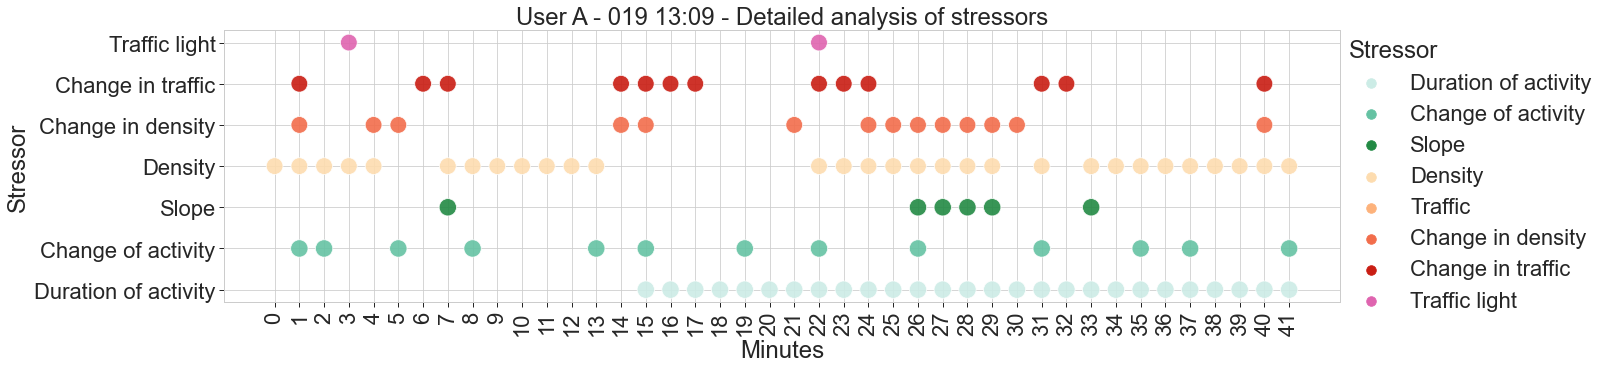

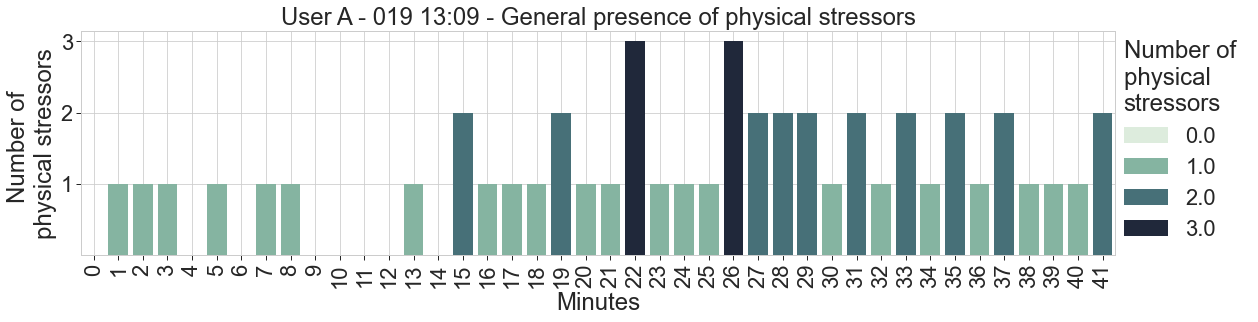

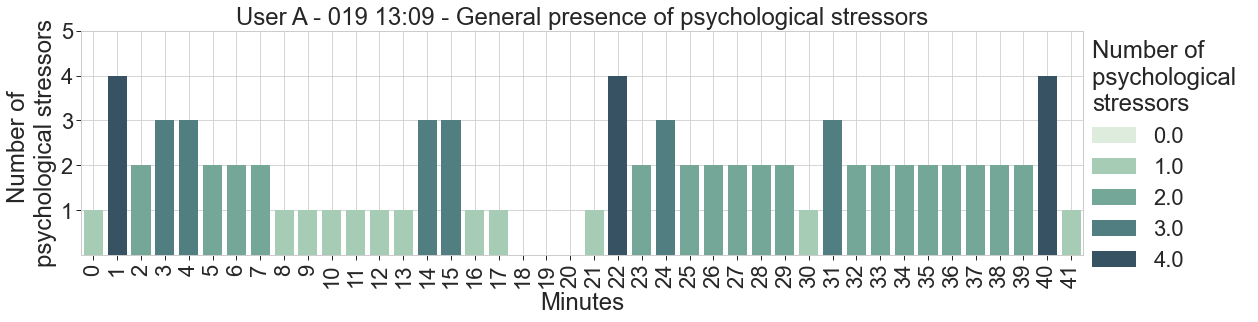

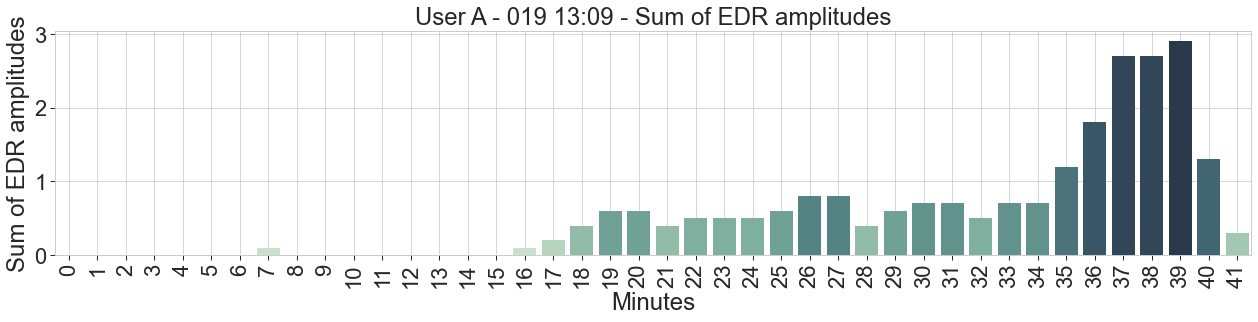

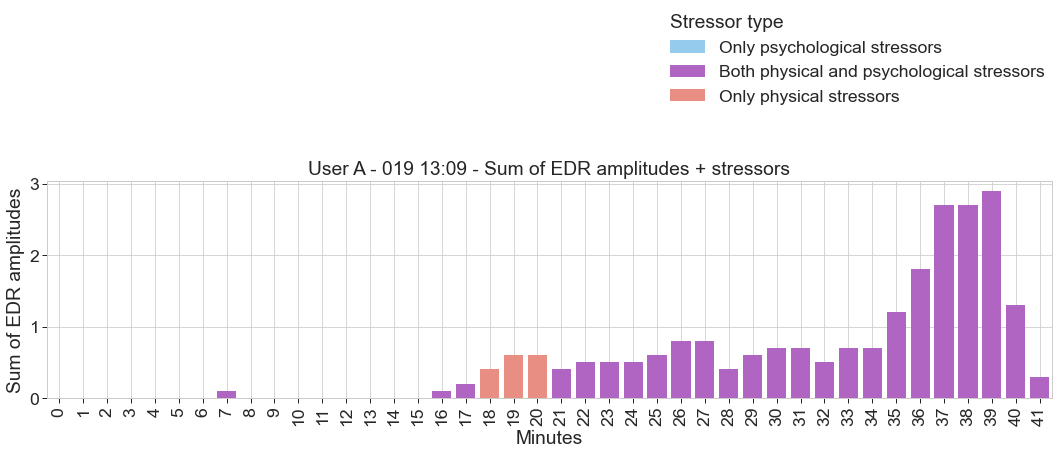

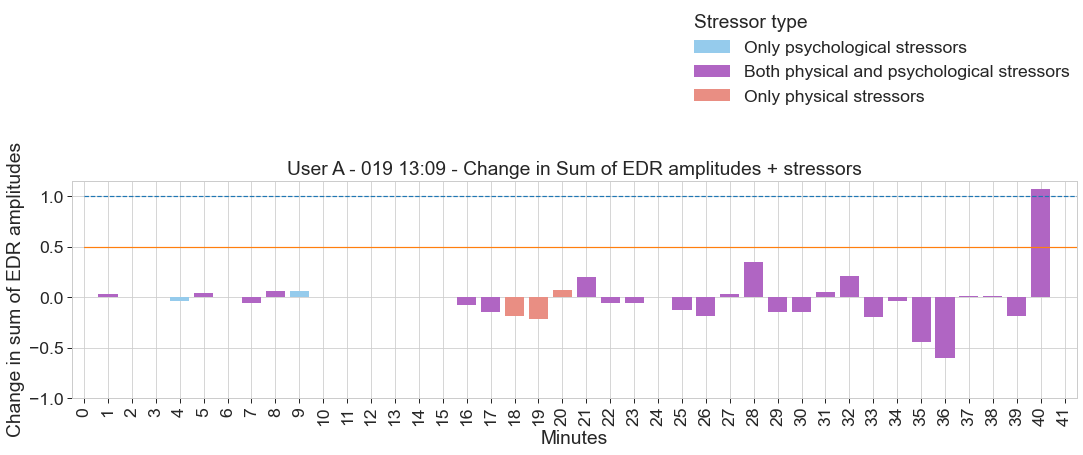

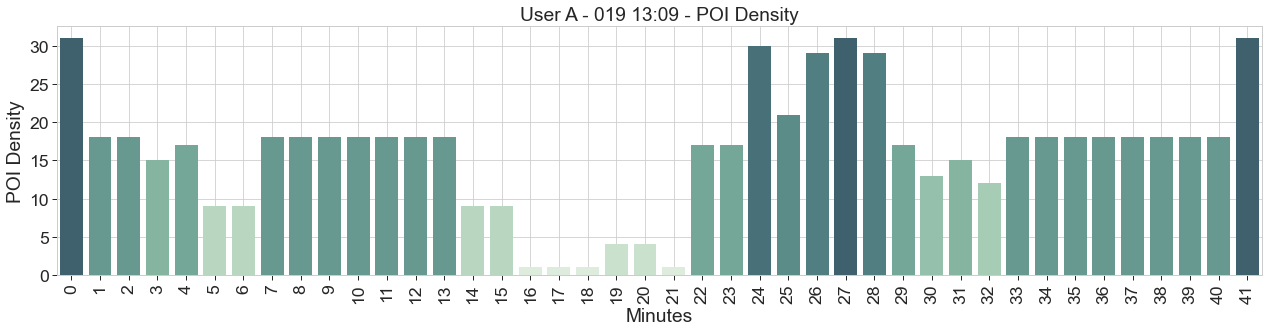

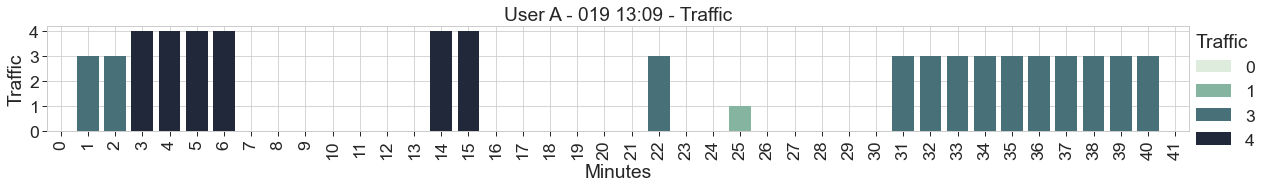

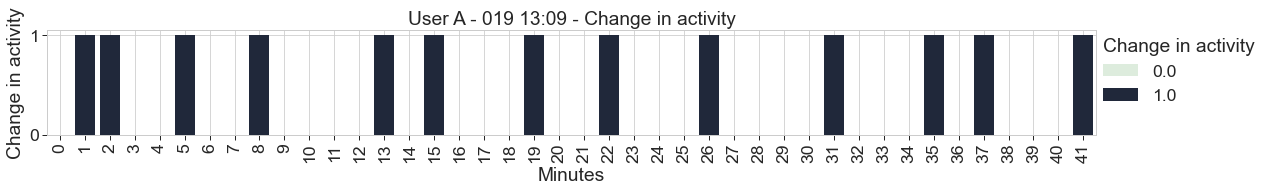

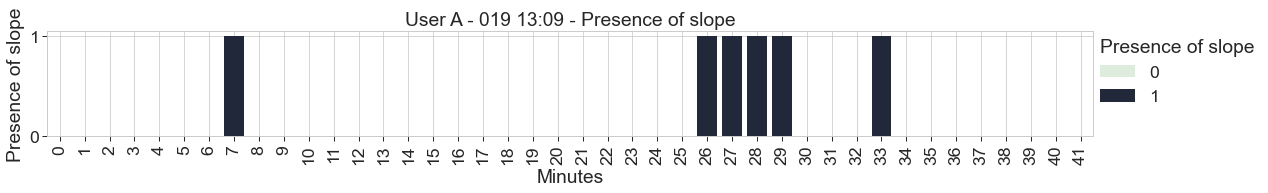

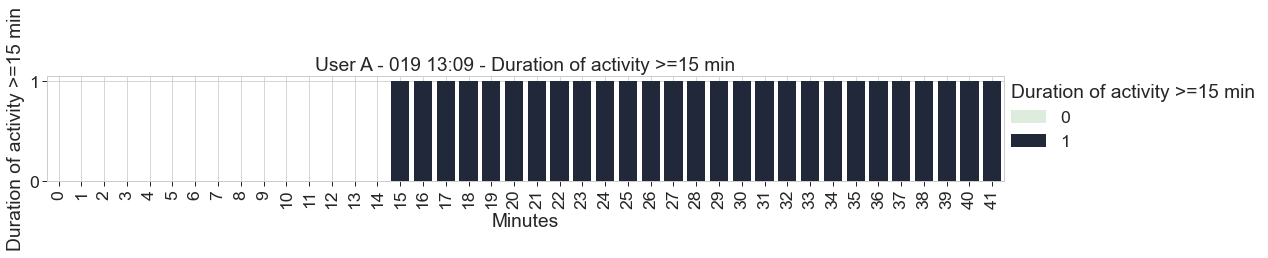

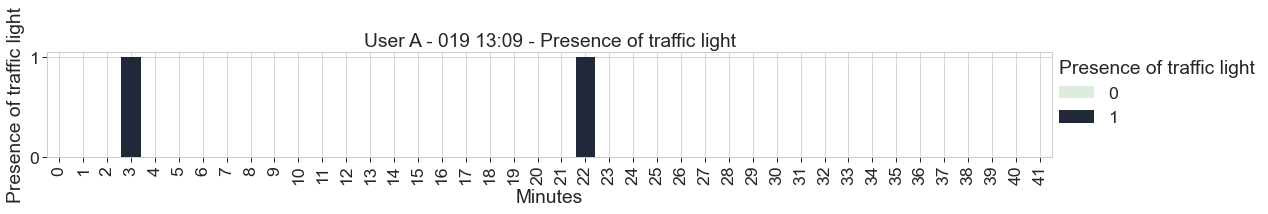

In [27]:
sns.set_context('paper',font_scale=2.5)

for ses in fusion_df['Session'].unique():
    this_session = fusion_df[fusion_df['Session']==ses].copy()
    # Sometimes some seconds are not included in the index and we have to include them to create even bars
    this_session = this_session.resample('1s').mean().fillna(method='bfill').fillna(method='ffill')
    this_session['Index']=this_session.index
    this_session['Significant change in sum of EDR amplitudes']=0
    this_session['Sum of EDR amplitudes'] = this_session['Sum of EDR amplitudes'].round(1)
    this_session['Sum of EDR amplitudes'] = this_session['Sum of EDR amplitudes'].astype('float64')
    this_session['Xticks']=np.arange(len(this_session))


    # Make the values integers for the data that we are displaying (because they are displayed as floats in the legend)
    this_session['Total seconds passed'] = this_session['Xticks'].astype('int64')
    this_session['Density'] = this_session['Density'].astype('int64')
    this_session['Traffic'] = this_session['Traffic'].astype('int64')
    this_session['Traffic signal'] = this_session['Traffic signal'].astype('int64')

    
    #--------Make new dfs for visualization of physical stressors
    helper_df_for_visualisation = this_session[::60].copy()
    xticks_df = pd.DataFrame(helper_df_for_visualisation['Xticks'].copy())
    # make a supporting df to store the data points where there is a presence of slope
    slope_df = pd.DataFrame(helper_df_for_visualisation[helper_df_for_visualisation['Altitude change_slope']>0]['Xticks'].copy())
    slope_df['Physical stressor']='Slope'
    slope_df['Something']=1
    # make a supporting df to store the data points where the duration of activity is > 15 mins
    duration_df = pd.DataFrame(helper_df_for_visualisation[helper_df_for_visualisation['Total seconds passed']>=900]['Xticks'].copy())
    duration_df['Physical stressor']='Duration of activity'
    duration_df['Something']=1
    # make a supporting df to store the data points where there is a presence of a change in activity
    change_act_df = pd.DataFrame(helper_df_for_visualisation[helper_df_for_visualisation['Change of activity']==1]['Xticks'].copy())
    change_act_df['Physical stressor']='Change of activity'
    change_act_df['Something']=1
    
    visualise_physical_stressors = pd.concat([duration_df, change_act_df, slope_df], axis=0)




    #make new dfs for visualisation of psychological stressors:
    # make a supporting df to store the data points where there is a presence of high POI density
    dens_df = pd.DataFrame(helper_df_for_visualisation[helper_df_for_visualisation['Density']>=15]['Xticks'].copy())
    dens_df['Psychological stressor']='Density'
    dens_df['Dummy']=1
    # make a supporting df to store the data points where there is a presence of significant changes in density
    dens_ch_df = pd.DataFrame(helper_df_for_visualisation[helper_df_for_visualisation['Significant Changes:Density']==1]['Xticks'].copy())
    dens_ch_df['Psychological stressor']='Change in density'
    dens_ch_df['Dummy']=1
    # make a supporting df to store the data points where there is a presence of intense traffic
    traf_df = pd.DataFrame(helper_df_for_visualisation[helper_df_for_visualisation['Traffic']>=3]['Total seconds passed'].copy())
    traf_df['Psychological stressor']='Traffic'
    traf_df['Dummy']=1
    # make a supporting df to store the data points where there is a presence of significant changes in traffic levels
    traf_ch_df = pd.DataFrame(helper_df_for_visualisation[helper_df_for_visualisation['Significant Changes:Traffic']>=1]['Xticks'].copy())
    traf_ch_df['Psychological stressor']='Change in traffic'
    traf_ch_df['Dummy']=1


    # combine the supporting dfs related to psychological stressors
    visualise_psychological_stressors = pd.concat([dens_df, traf_df, dens_ch_df, traf_ch_df], axis=0)


    #make a new df for visualisation of psychological and physical stressors
    # make a supporting df to mark the points where there is a traffic light
    tr_l_df = pd.DataFrame(helper_df_for_visualisation[helper_df_for_visualisation['Traffic signal']==1]['Xticks'].copy())
    tr_l_df['Psychological and physical stressor']='Traffic light'
    tr_l_df['Dummy']=1


    #Find the points with no stressors for both categories 
    all_stressors_df = pd.concat([dens_df, traf_df, dens_ch_df, traf_ch_df,duration_df, change_act_df, slope_df, tr_l_df], axis=0)
    no_stressors_df=xticks_df.loc[~xticks_df.index.isin(all_stressors_df.index)].copy()
    no_stressors_df['Psychological stressor']='None'
    no_stressors_df['Physical stressor']='None'
    no_stressors_df['Dummy']=1



    # Assign distinction between physical and psychological stressors (basic categorization)
    this_session['Stressor type']=0
    this_session.loc[this_session[(this_session['Physical stressors']>0) & (this_session['Psychological stressors']==0)].index,'Stressor type']='Only physical stressors'
    this_session.loc[this_session[(this_session['Physical stressors']==0) & (this_session['Psychological stressors']>0)].index,'Stressor type']='Only psychological stressors'
    this_session.loc[this_session[(this_session['Physical stressors']>0) & (this_session['Psychological stressors']>0)].index,'Stressor type']='Both physical and psychological stressors'
    this_session.loc[this_session[(this_session['Physical stressors']==0) & (this_session['Psychological stressors']==0)].index,'Stressor type']='No identifiable source'





    # CREATE PLOTS TO VISUALISE THE RESULTS OF THE ANALYSIS
    # ----PLOT: A detailed description of the stressors for each minute
    # Here we use the supporting dfs that we created above
    if (this_session['Xticks'].max()/60)>60:
        sns.set_context('paper',font_scale=2)
    else:
        sns.set_context('paper',font_scale=2.5)
    plt.figure(figsize=(20,5))
    step=30
    a3 = sns.scatterplot(data = no_stressors_df, x = 'Xticks',y='Physical stressor',
                    hue = no_stressors_df['Physical stressor'].to_list(), palette='Greys', s=280,
                         alpha=0.9)
    a = sns.scatterplot(data = visualise_physical_stressors, x = 'Xticks',y='Physical stressor',
                    hue=visualise_physical_stressors['Physical stressor'].to_list(),palette='BuGn', s=300,
                         alpha=0.9)
    a2 = sns.scatterplot(data = visualise_psychological_stressors, x = 'Xticks',y='Psychological stressor',
                    hue=visualise_psychological_stressors['Psychological stressor'].to_list(),palette='OrRd', s=280,
                         alpha=0.9)
    a4 = sns.scatterplot(data = tr_l_df, x = 'Xticks',y='Psychological and physical stressor', 
                         hue = tr_l_df['Psychological and physical stressor'].to_list(),palette='PuRd',
                         s=280,
                         alpha=0.9)
    a.xaxis.grid(b=True)
    loc,labels = plt.xticks()
    plt.xticks(xticks_df['Xticks'],(xticks_df['Xticks']/60).astype('int64'), rotation=90)
    a.yaxis.grid(b=True, which='both')
    plt.xlabel('Minutes')
    plt.ylabel('Stressor')
    leg = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,
               title = 'Stressor', ncol=1 ,markerscale=2)
    leg._legend_box.align = "left"
    plt.setp(leg.get_title(),fontsize='medium')
    plt.title('User X'.replace('X', User_Letter) + ' - ' + str(ses[9:]) +  ' - Detailed analysis of stressors')




    #---PLOT: General presence of physical stressors
    plt.figure(figsize=(18,5))
    palette_2 = sns.cubehelix_palette(start = -21, rot=-.4, light=0.9,
                                      n_colors=len(this_session['Physical stressors'].unique()+1))
    s = sns.barplot(data=this_session[::60], x='Xticks',
                y='Physical stressors', hue='Physical stressors',
               palette = palette_2, dodge=False)
    loc,labels = plt.xticks()
    plt.yticks(np.arange(this_session['Physical stressors'].max())+1)
    plt.xticks(loc,(this_session[::60]['Xticks']/60).astype(int), rotation=90)
    plt.xlabel('Minutes')
    plt.grid(b=True,axis='both')
    leg = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,
               title = 'Number of \nphysical \nstressors', ncol=1 ,markerscale=2)
    leg._legend_box.align = "left"
    plt.setp(leg.get_title(),fontsize='medium')
    plt.ylabel('Number of \nphysical stressors')
    plt.title('User X'.replace('X', User_Letter) + ' - ' + str(ses[9:]) +  ' - General presence of physical stressors')
    plt.tight_layout()


    
    
    
    # ----PLOT: General presence of psychological stressors
    plt.figure(figsize=(18,5))
    palette_2 = sns.cubehelix_palette(start = -21, rot=-.4, light=0.9,
                                      n_colors=len(this_session['Psychological stressors'].unique()+1))
    s = sns.barplot(data=this_session[::60], x='Xticks',
                y='Psychological stressors', hue='Psychological stressors',
               palette = palette_2, dodge=False)
    loc,labels = plt.xticks()
    plt.yticks(np.arange(this_session['Psychological stressors'].max())+1)
    plt.xticks(loc,(this_session[::60]['Xticks']/60).astype(int), rotation=90)
    plt.xlabel('Minutes')
    plt.grid(b=True,axis='both')
    leg = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,
               title = 'Number of \npsychological \nstressors', ncol=1 ,markerscale=2)
    leg._legend_box.align = "left"
    plt.setp(leg.get_title(),fontsize='medium')
    plt.ylabel('Number of \npsychological stressors')
    plt.title('User X'.replace('X', User_Letter) + ' - ' + str(ses[9:]) +  ' - General presence of psychological stressors')
    plt.tight_layout()



    # ----PLOT:  Sum of EDR amplitudes, with bars coloured based on intensity of responses 
    plt.figure(figsize=(18,5))
    palette_2 = sns.cubehelix_palette(start = -21, rot=-.4, light=0.9,
                                      n_colors=len(this_session['Sum of EDR amplitudes'].unique()))
    s = sns.barplot(data=this_session[::60], x='Xticks',
                y='Sum of EDR amplitudes', hue='Sum of EDR amplitudes',
               palette = palette_2, dodge=False)
    loc,labels = plt.xticks()
    plt.xticks(loc,(this_session[::60]['Xticks']/60).astype(int), rotation=90)
    plt.xlabel('Minutes')
    plt.ylabel('Sum of EDR amplitudes')
    plt.grid(b=True,axis='both')
    s.legend_.remove()
    plt.title('User X'.replace('X', User_Letter) + ' - ' + str(ses[9:]) +  ' - Sum of EDR amplitudes')
    plt.tight_layout()



    # ----PLOT: Sum of EDR amplitudes, coloured based on classification of stressors (physical, psychological, combined)
    if (this_session['Xticks'].max()/60)>60:
        sns.set_context('paper',font_scale=1.7)
    else:
        sns.set_context('paper',font_scale=2)
    plt.figure(figsize=(18,4))
    palette_2 = sns.cubehelix_palette(start = -21, rot=-.4, light=0.7,
                                      n_colors=3)
    sns.barplot(data=this_session[::60], x='Xticks',
                y='Sum of EDR amplitudes', hue = 'Stressor type', 
               palette = stressor_color_dict, dodge=False)
    loc,labels = plt.xticks()
    plt.xticks(loc,(this_session[::60]['Xticks']/60).astype(int), rotation=90)
    plt.xlabel('Minutes')
    plt.ylabel('Sum of EDR amplitudes')
    plt.grid(b=True,axis='both')
    leg = plt.legend(bbox_to_anchor=(1, 1.8), loc='upper right', borderaxespad=0.,
               title = 'Stressor type', ncol=1)
    plt.setp(leg.get_title(),fontsize='medium')
    leg._legend_box.align = "left"
    plt.title('User X'.replace('X', User_Letter) + ' - ' + str(ses[9:]) +  ' - Sum of EDR amplitudes + stressors')
    
    
    
    

    # ----PLOT: Changes in Sum of EDR amplitudes, coloured based on classification of stressors (physical, psychological, combined)
    plt.figure(figsize=(18,4))
    palette_2 = sns.cubehelix_palette(start = -21, rot=-.4, light=0.7,
                                      n_colors=3)
    ax1 = sns.lineplot(data=this_session[::60], x='Xticks', y=1)
    ax1.lines[0].set_linestyle("--")
    ax2 = sns.lineplot(data=this_session[::60], x='Xticks', y=0.5)
    ax2.lines[0].set_linestyle("--")
    sns.barplot(data=this_session[::60], x='Xticks', y='Significant Changes:Sum of EDR amplitudes', hue = 'Stressor type', palette = stressor_color_dict, dodge=False)
    loc,labels = plt.xticks()
    changes_min = this_session['Significant Changes:Sum of EDR amplitudes'].min()
    if changes_min<0:
        changes_min = changes_min-changes_min%0.5
    else:
        changes_min = changes_min+changes_min%0.5
    changes_max = this_session['Significant Changes:Sum of EDR amplitudes'].max()
    if changes_max<0:
        changes_max = changes_max-changes_max%0.5
    else:
        changes_max = changes_max+changes_max%0.5
    plt.yticks(np.arange(changes_min, changes_max, 0.5))
    plt.xticks(loc,(this_session[::60]['Xticks']/60).astype(int), rotation=90)
    plt.xlabel('Minutes')
    plt.ylabel('Change in sum of EDR amplitudes')
    plt.grid(b=True,axis='both')
    leg = plt.legend(bbox_to_anchor=(1, 1.8), loc='upper right', borderaxespad=0.,
               title = 'Stressor type', ncol=1)
    plt.setp(leg.get_title(),fontsize='medium')
    leg._legend_box.align = "left"
    plt.title('User X'.replace('X', User_Letter) + ' - ' + str(ses[9:]) +  ' - Change in Sum of EDR amplitudes + stressors')
    
    
    
    
    
    #---------------------PLOT GRAPHS FOR CONTEXTUAL DATA
    # Density
    plt.figure(figsize=(18,5))
    palette_2 = sns.cubehelix_palette(start = -21, rot=-.4, light=0.9,
                                      n_colors=len(this_session['Density'].unique()+1))
    s = sns.barplot(data=this_session[::60], x='Xticks',
                y='Density', hue='Density',
               palette = palette_2, dodge=False)
    loc,labels = plt.xticks()
    plt.xticks(loc,(this_session[::60]['Xticks']/60).astype(int), rotation=90)
    plt.xlabel('Minutes')
    plt.grid(b=True,axis='both')
    plt.setp(leg.get_title(),fontsize='medium')
    plt.ylabel('POI Density')
    s.legend_.remove()
    plt.title('User X'.replace('X', User_Letter) + ' - ' + str(ses[9:]) +  ' - POI Density')
    plt.tight_layout()
    
    
    
    
    #  ----PLOT:  Traffic
    plt.figure(figsize=(18,3))
    palette_2 = sns.cubehelix_palette(start = -21, rot=-.4, light=0.9,
                                      n_colors=len(this_session['Traffic'].unique()+1))
    s = sns.barplot(data=this_session[::60], x='Xticks',
                y='Traffic', hue='Traffic',
               palette = palette_2, dodge=False)
    loc,labels = plt.xticks()
    plt.yticks(np.arange(this_session['Traffic'].max()+1))
    plt.xticks(loc,(this_session[::60]['Xticks']/60).astype(int), rotation=90)
    plt.xlabel('Minutes')
    plt.grid(b=True,axis='both')
    leg = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,
               title = 'Traffic', ncol=1 ,markerscale=2)
    leg._legend_box.align = "left"
    plt.setp(leg.get_title(),fontsize='medium')
    plt.ylabel('Traffic')
    plt.title('User X'.replace('X', User_Letter) + ' - ' + str(ses[9:]) +  ' - Traffic')
    plt.tight_layout()
    
    
    #---------------------PLOT GRAPHS FOR PHYSICAL STRESSORS
    #  ----PLOT:  Change of activity
    plt.figure(figsize=(18,3))
    palette_2 = sns.cubehelix_palette(start = -21, rot=-.4, light=0.9,
                                      n_colors=len(this_session['Change of activity'].unique()+1))
    s = sns.barplot(data=this_session[::60], x='Xticks',
                y='Change of activity', hue='Change of activity',
               palette = palette_2, dodge=False)
    loc,labels = plt.xticks()
    plt.yticks(np.arange(this_session['Change of activity'].max()+1))
    plt.xticks(loc,(this_session[::60]['Xticks']/60).astype(int), rotation=90)
    plt.xlabel('Minutes')
    plt.grid(b=True,axis='both')
    leg = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,
               title = 'Change in activity', ncol=1 ,markerscale=2)
    leg._legend_box.align = "left"
    plt.setp(leg.get_title(),fontsize='medium')
    plt.ylabel('Change in activity')
    plt.title('User X'.replace('X', User_Letter) + ' - ' + str(ses[9:]) +  ' - Change in activity')
    plt.tight_layout()



    #  ----PLOT:  Altitude change 
    this_session['Presence of slope']=0
    this_session.loc[this_session[this_session['Altitude change_slope']!=0].index, 'Presence of slope']=1


    plt.figure(figsize=(18,3))
    palette_2 = sns.cubehelix_palette(start = -21, rot=-.4, light=0.9,
                                      n_colors=len(this_session['Presence of slope'].unique()+1))
    s = sns.barplot(data=this_session[::60], x='Xticks',
                y='Presence of slope', hue='Presence of slope',
               palette = palette_2, dodge=False)
    loc,labels = plt.xticks()
    plt.yticks(np.arange(this_session['Presence of slope'].max()+1))
    plt.xticks(loc,(this_session[::60]['Xticks']/60).astype(int), rotation=90)
    plt.xlabel('Minutes')
    plt.grid(b=True,axis='both')
    leg = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,
               title = 'Presence of slope', ncol=1 ,markerscale=2)
    leg._legend_box.align = "left"
    plt.setp(leg.get_title(),fontsize='medium')
    plt.ylabel('Presence of slope')
    plt.title('User X'.replace('X', User_Letter) + ' - ' + str(ses[9:]) +  ' - Presence of slope')
    plt.tight_layout()

    
    
    

    #  ----PLOT:  Duration of activity 
    this_session['Duration of activity >=15 min']=0
    this_session.loc[this_session[this_session['Total seconds passed']>=900].index, 'Duration of activity >=15 min']=1

    plt.figure(figsize=(18,3))
    palette_2 = sns.cubehelix_palette(start = -21, rot=-.4, light=0.9,
                                      n_colors=len(this_session['Duration of activity >=15 min'].unique()+1))
    s = sns.barplot(data=this_session[::60], x='Xticks',
                y='Duration of activity >=15 min', hue='Duration of activity >=15 min',
               palette = palette_2, dodge=False)
    loc,labels = plt.xticks()
    plt.yticks(np.arange(this_session['Duration of activity >=15 min'].max()+1))
    plt.xticks(loc,(this_session[::60]['Xticks']/60).astype(int), rotation=90)
    plt.xlabel('Minutes')
    plt.grid(b=True,axis='both')
    leg = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,
               title = 'Duration of activity >=15 min', ncol=1 ,markerscale=2)
    leg._legend_box.align = "left"
    plt.setp(leg.get_title(),fontsize='medium')
    plt.ylabel('Duration of activity >=15 min')
    plt.title('User X'.replace('X', User_Letter) + ' - ' + str(ses[9:]) +  ' - Duration of activity >=15 min')
    plt.tight_layout()



    # ----PLOT:  Traffic signal
    plt.figure(figsize=(18,3))
    palette_2 = sns.cubehelix_palette(start = -21, rot=-.4, light=0.9,
                                      n_colors=len(this_session['Traffic signal'].unique()+1))
    s = sns.barplot(data=this_session[::60], x='Xticks',
                y='Traffic signal', hue='Traffic signal',
               palette = palette_2, dodge=False)
    loc,labels = plt.xticks()
    plt.yticks(np.arange(this_session['Traffic signal'].max()+1))
    plt.xticks(loc,(this_session[::60]['Xticks']/60).astype(int), rotation=90)
    plt.xlabel('Minutes')
    plt.grid(b=True,axis='both')
    leg = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,
               title = 'Presence of traffic light', ncol=1 ,markerscale=2)
    leg._legend_box.align = "left"
    plt.setp(leg.get_title(),fontsize='medium')
    plt.ylabel('Presence of traffic light')

    plt.title('User X'.replace('X', User_Letter) + ' - ' + str(ses[9:]) +  ' - Presence of traffic light')
    plt.tight_layout()



#### Calculate exposure to stressors

In [28]:

for ses in fusion_df['Session'].unique():
    this_session = fusion_df[fusion_df['Session']==ses].copy()
    # Sometimes some seconds are not included in the index and we have to include them to create even bars
    this_session = this_session.resample('1s').mean().fillna(method='bfill').fillna(method='ffill')

    this_session['Steady state walking']=0
    this_session.loc[this_session[(this_session['Steady state']==1)&(this_session['activity']==2)].index, 'Steady state walking']=1



    print('Percentage of Physical:', len(this_session[this_session['Physical stressors']>0])/len(this_session))
    print('Percentage of Psychological:', len(this_session[this_session['Psychological stressors']>0])/len(this_session))
    # This is calculated based on the EDA data (using the sum of EDR amplitudes as an indicator of physiological responses)
    if len(this_session[this_session['Sum of EDR amplitudes']>0])!=0:
        print('Percentage of Physiological responses during physical', len(this_session[(this_session['Sum of EDR amplitudes']>0) & (this_session['Physical stressors']>0) & (this_session['Psychological stressors']==0)])/len(this_session[this_session['Sum of EDR amplitudes']>0]))
        # It can be modified for HR like this:
        # print('Percentage of Physiological responses during physical', len(this_session[(abs(this_session['Significant Changes:Heart rate'])>10) & (this_session['Physical stressors']>0) & (this_session['Psychological stressors']==0)])/len(this_session[abs(this_session['Significant Changes:Heart rate'])>10]))
        # The other percentages can be modified in the same way
        print('Percentage of Physiological responses during psychological', len(this_session[(this_session['Sum of EDR amplitudes']>0) & (this_session['Physical stressors']==0) & (this_session['Psychological stressors']>0)])/len(this_session[this_session['Sum of EDR amplitudes']>0]))
        print('Percentage of Physiological responses during physical + psychological', len(this_session[(this_session['Sum of EDR amplitudes']>0) & (this_session['Physical stressors']>0) & (this_session['Psychological stressors']>0)])/len(this_session[this_session['Sum of EDR amplitudes']>0]))
        print('Percentage of Physiological responses during only steady state walking', len(this_session[(this_session['Sum of EDR amplitudes']>0) & (this_session['Physical stressors']==0) & (this_session['Psychological stressors']==0) & (this_session['Steady state walking']==1)])/len(this_session[this_session['Sum of EDR amplitudes']>0]))
        print('Percentage of Physiological responses after 15 mins of activity without other stressors', len(this_session[(this_session['Sum of EDR amplitudes']>0) & (this_session['Total seconds passed']>=900) & (this_session['Change of activity']==0) & (this_session['Psychological stressors']==0)])/len(this_session[this_session['Sum of EDR amplitudes']>0]))

    print('Route duration:', this_session['Total seconds passed'][-1]/60)

        

Percentage of Physical: 0.7895582329317269
Percentage of Psychological: 0.9273092369477912
Percentage of Physiological responses during physical 0.09296353364149974
Percentage of Physiological responses during psychological 0.11145351823317926
Percentage of Physiological responses during physical + psychological 0.795582948125321
Percentage of Physiological responses during only steady state walking 0.0
Percentage of Physiological responses after 15 mins of activity without other stressors 0.060092449922958396
Route duration: 41.55


# Save

In [29]:
# Save the constructed dataframe (containing the results of fusion 
# of physiological, movement and contextual data)
#path_to_save = 'ZZZZZZZ.csv' # Put here the desired path, ending in .csv so that the file is saved as a csv
# For the example displayed in the file 'Step 1 - Process EDA, accelerometer and skin temperature data', 
# I used the following path:
path_to_save = r'C:\Users\demdr\Desktop\Testing the thesis functions\Project data\Analysed data\Participants\A\After data fusion\Session 1.csv'

fusion_df.fillna(0).to_csv(path_to_save)